- 데이터 필터링은 charge session 단위가 아니라 'cid' 단위로 할것.
    - 동일 cid의 일부 charge sessio을 제외할 경우 시간순에 따라 windowing을 하여 피쳐를 생성하는 과정에서 왜곡이 발생함

In [89]:
import pandas as pd

pd.options.display.float_format = '{: .2f}'.format

In [90]:
# 가장 최근의 2021년 7월~ 12월 (6개월) 데이터 로드

df = pd.read_csv('../data/한국전력공사_전기차충전소충전량(202107_202112).csv', 
                 parse_dates=['충전종료일자', '충전시작시각', '충전종료시각'], 
                 encoding='cp949')

In [91]:
df.head()

,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,충전시간,충전분,충전종료일자,충전시작시각,충전종료시각
0,강원,강원직할,강원직할,완속05,1296,강원도 춘천시 수풍골길 7,완속,7.00,13.17,2,39,2021-07-01,2021-07-01 19:35:55,2021-07-01 22:15:42
1,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,15.84,0,24,2021-07-01,2021-07-01 14:30:46,2021-07-01 14:54:51
2,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,11.70,0,43,2021-07-01,2021-07-01 16:52:38,2021-07-01 17:36:36
3,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.40,1,23,2021-07-01,2021-07-01 10:58:58,2021-07-01 12:22:29
4,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.53,2,11,2021-07-01,2021-07-01 16:46:25,2021-07-01 18:58:12


In [92]:
drop_cols = ['본부', '사업소', '충전소명', '충전기', '주소', '충전종료일자']
rename_dict = {'충전기ID':'cid', '충전기구분':'charger_type', '충전용량':'charging_power', 
               '충전량':'charge_amount', '충전시간':'hour', '충전분':'minute',
               '충전시작시각':'start_time', '충전종료시각':'finish_time'}

# df = df.drop(drop_cols, axis=1)
df = df.rename(columns=rename_dict)
df = df.loc[df['charger_type'] == '급속']
df['duration'] = df.hour.multiply(60).add(df.minute)
df = df.drop(['charger_type', 'hour', 'minute'], axis=1)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583023 entries, 1 to 1048572
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   본부              583023 non-null  object        
 1   사업소             583023 non-null  object        
 2   충전소명            583023 non-null  object        
 3   충전기             583023 non-null  object        
 4   cid             583023 non-null  int64         
 5   주소              582745 non-null  object        
 6   charging_power  556320 non-null  float64       
 7   charge_amount   583023 non-null  float64       
 8   충전종료일자          583023 non-null  datetime64[ns]
 9   start_time      583023 non-null  datetime64[ns]
 10  finish_time     583023 non-null  datetime64[ns]
 11  duration        583023 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 57.8+ MB


In [94]:
# 8080개 device
df.cid.nunique()

8080

In [95]:
# 7~12월 간의 데이터이지만 실질적으로 10월 17일까지의 로그만 존재함
df.describe(datetime_is_numeric=True)

# 7~9의 3개월 데이터만 분리
df = df[df.start_time.between('2021-07-01', '2021-10-01')]
df.cid.nunique()

7723

In [96]:
# 실질적으로 활발히 운영되는 충전기로 한정하기 위하여, 분석기간(3개월) 내 첫주와 마지막주에 모두 충전시작이 있는 충전기로 제한

first_charge = df.groupby('cid')['start_time'].min()
valid_id_first = first_charge[first_charge < '2021-07-07'].index

last_charge = df.groupby('cid')['start_time'].max()
valid_id_last = last_charge[last_charge > '2021-09-23'].index

In [97]:
# 총 3,213개의 충전기
valid_cid = set(valid_id_first).intersection(valid_id_last)
len(valid_cid)

3213

In [98]:
# 총 충전의 90% 이상이며 3개월간 441,530건
df.cid.isin(valid_cid).mean(), df.cid.isin(valid_cid).sum()

(0.9060910215866905, 441530)

In [99]:
# valid_cid의 로그만 선택하여 charge 테이블 생성
charge = df[df.cid.isin(valid_cid)].copy()

In [100]:
charge.head()

,본부,사업소,충전소명,충전기,cid,주소,charging_power,charge_amount,충전종료일자,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [101]:
# charging_power에서 null 발생 ->  피쳐로 활용할 것 이므로 null row 제거
charge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441530 entries, 10 to 899545
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   본부              441530 non-null  object        
 1   사업소             441530 non-null  object        
 2   충전소명            441530 non-null  object        
 3   충전기             441530 non-null  object        
 4   cid             441530 non-null  int64         
 5   주소              441422 non-null  object        
 6   charging_power  436187 non-null  float64       
 7   charge_amount   441530 non-null  float64       
 8   충전종료일자          441530 non-null  datetime64[ns]
 9   start_time      441530 non-null  datetime64[ns]
 10  finish_time     441530 non-null  datetime64[ns]
 11  duration        441530 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 43.8+ MB


In [102]:
power_null_ids = charge[charge.charging_power.isna()].cid.unique()
charge = charge[~charge.cid.isin(power_null_ids)]

In [103]:
charge.charging_power.unique()

array([ 50., 200., 100.])

### duration 이상치 필터링

In [104]:
charge.duration.describe()

count    436187.00
mean         51.09
std          83.39
min           0.00
25%          25.00
50%          42.00
75%          66.00
max       24369.00
Name: duration, dtype: float64

In [105]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(charge.duration)

(-208.18165142488976, 292.18165142488976)

In [106]:
# 292분 초과하는 경우 1,915건으로 전체 중 0.4% 가량
charge.duration.gt(outlier_bound(charge.duration)[1]).sum(), charge.duration.gt(outlier_bound(charge.duration)[1]).mean()

(1915, 0.004390318831143524)

In [107]:
outlier_cid = charge[charge.duration.gt(outlier_bound(charge.duration)[1])].cid.unique()

In [108]:
charge = charge[~charge.cid.isin(outlier_cid)]

In [109]:
# 2453개의 cid
charge.cid.nunique()

2453

In [110]:
# 충전기당-일당 충전횟수는 최대 24.48회 최소 0.03회
charge.groupby('cid')['charging_power'].count().divide(92).describe()

count    2453.00
mean        1.58
std         1.84
min         0.03
25%         0.51
50%         1.03
75%         2.02
max        24.48
Name: charging_power, dtype: float64

<AxesSubplot: ylabel='Frequency'>

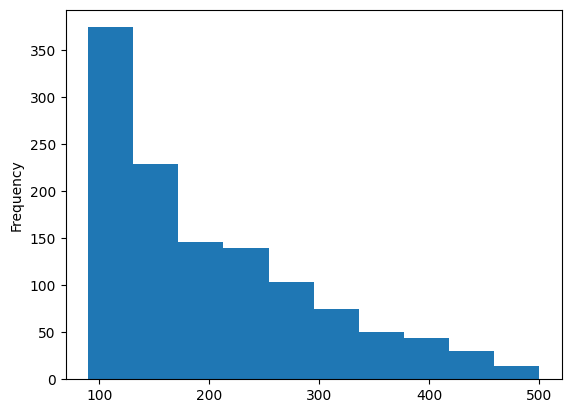

In [111]:
charge.groupby('cid')['charging_power'].count().plot(kind='hist', range=(90,500))

In [112]:
# 충전소명으로 집계 가능 확인 ->  cid가 여러 충전소명 가지고있는 경우 없음
n_office = charge.groupby('cid')['충전소명'].nunique()
n_office[n_office>1]

Series([], Name: 충전소명, dtype: int64)

In [114]:
charge.head()

,본부,사업소,충전소명,충전기,cid,주소,charging_power,charge_amount,충전종료일자,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [116]:
drop_cols = ['본부', '사업소','충전기', '주소', '충전종료일자']
charge = charge.drop(columns=drop_cols)

### start ->  finish 정보로 부터 step별 occupancy 여부 생성

In [117]:
from tqdm import tqdm
tqdm.pandas()

sample = charge.query("cid == 8833")

# 7,8,9월 31, 31, 30일
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
data = pd.Series(index=TIME_IDX, data=0)

result = np.full(TIME_IDX.shape[0], False)

for start_time, finish_time in tqdm((zip(sample.start_time, sample.finish_time))):
    occupied = (TIME_IDX >= start_time) & (TIME_IDX <= finish_time)
    result = result | occupied

pd.Series(data=result, index=TIME_IDX)

127it [00:00, 7993.59it/s]


2021-07-01 00:00:00    False
2021-07-01 00:10:00    False
2021-07-01 00:20:00    False
2021-07-01 00:30:00    False
2021-07-01 00:40:00    False
                       ...  
2021-09-30 23:10:00    False
2021-09-30 23:20:00    False
2021-09-30 23:30:00    False
2021-09-30 23:40:00    False
2021-09-30 23:50:00    False
Freq: 10T, Length: 13248, dtype: bool

In [147]:
from tqdm import tqdm
tqdm.pandas()


def check_occupancy(cid_df):
    TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)  # 7,8,9월 31, 31, 30일
    result = np.full(TIME_IDX.shape[0], False)

    for start_time, finish_time in zip(cid_df.start_time, cid_df.finish_time):
        occupied = (TIME_IDX >= start_time) & (TIME_IDX <= finish_time)
        result = result | occupied
    return pd.Series(data=result, index=TIME_IDX)

In [152]:
df = charge.groupby('cid')[['start_time', 'finish_time']].progress_apply(check_occupancy).astype(np.int32)

100%|██████████| 2453/2453 [00:36<00:00, 66.41it/s] 


In [183]:
df.reset_index().merge(charge[['cid', '충전소명']].drop_duplicates(), how='left', on='cid')

,cid,2021-07-01 00:00:00,2021-07-01 00:10:00,2021-07-01 00:20:00,2021-07-01 00:30:00,2021-07-01 00:40:00,2021-07-01 00:50:00,2021-07-01 01:00:00,2021-07-01 01:10:00,2021-07-01 01:20:00,...,2021-09-30 22:30:00,2021-09-30 22:40:00,2021-09-30 22:50:00,2021-09-30 23:00:00,2021-09-30 23:10:00,2021-09-30 23:20:00,2021-09-30 23:30:00,2021-09-30 23:40:00,2021-09-30 23:50:00,충전소명
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,음성휴게소(통영방향)
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,오창휴게소(통영방향)
2,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,이천휴게소(통영방향)
3,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,한전본사 남측주차장(공용)
4,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,한전본사 파빌리온주차장(공용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448,11045,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,천지공영주차장
2449,11049,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,동광리버스차고지
2450,11050,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,천지공영주차장
2451,11055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,표선공영주차장


In [ ]:
# 다음 단계  ->  충전소별로 집계 필요